In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.figsize':(8,6)})

In [2]:
df = pd.read_csv('nyc_energy_consumption.csv')
df.index = pd.to_datetime(df['timeStamp'])

In [3]:
df.head()

,timeStamp,demand,precip,temp
timeStamp,,,,
2012-01-01 00:00:00,2012-01-01 00:00:00,4937.5,0.0,46.13
2012-01-01 01:00:00,2012-01-01 01:00:00,4752.1,0.0,45.89
2012-01-01 02:00:00,2012-01-01 02:00:00,4542.6,0.0,45.04
2012-01-01 03:00:00,2012-01-01 03:00:00,4357.7,0.0,45.03
2012-01-01 04:00:00,2012-01-01 04:00:00,4275.5,0.0,42.61


array([<AxesSubplot:xlabel='timeStamp'>, <AxesSubplot:xlabel='timeStamp'>,
       <AxesSubplot:xlabel='timeStamp'>], dtype=object)

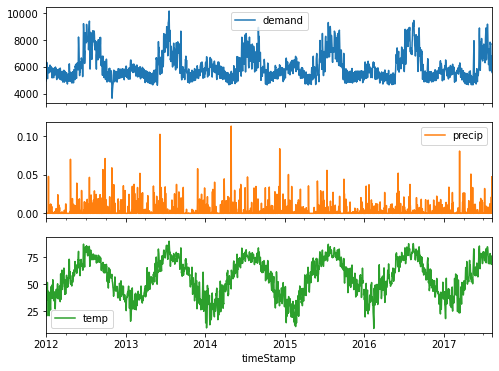

In [4]:
df.resample('d').mean().plot(subplots=True)

In [5]:
df_daily = df.resample('d').mean()
df_daily.head()

,demand,precip,temp
timeStamp,,,
2012-01-01,4954.833333,0.002487,46.510000
2012-01-02,5302.954167,0.000000,40.496667
2012-01-03,6095.512500,0.000000,26.672500
2012-01-04,6336.266667,0.000000,20.585000
2012-01-05,6130.245833,0.000000,33.577500


# Facebook Prophet :
1. for exaplained info : https://peerj.com/preprints/3190/
2. y(t) = g(t) + s(t) + h(t) + e(t)
3. y(t) is forcast variabel which we wants to predict
4. g(t) is model trend component , the trend component in this case can be a peice wise linear regression model which is a default model or it can be a logistic growth model. the prophet auto dectect the trend by points and it is done by the linear regression model that is runs internally.
5. s(t) is model seasonal component.
6. h(t) is of holidays which we can specify.
7. e(t) is residual or error component of data which assumed always normally distributed.
8. when data has seasonality as well as trend this may not the good model , for that the multiplactive model comes in a picture

In [6]:
from fbprophet import Prophet

In [7]:
# converting the column names because the prophet take it in this format
# the time column it need to be named 'ds' and target column as 'y'

In [8]:
df_final = df_daily.reset_index()[['timeStamp','demand']].rename({'timeStamp':'ds','demand':'y'},axis=1)

In [9]:
df_final.shape

(2051, 2)

In [10]:
train = df_final.iloc[:1947,:]  # date 2012-01-01 to 2017-04-30
test = df_final.iloc[1947: ,:]  # 2017-04-30 to last 2017-08-12

In [11]:
print(train.shape)
print(test.shape)

(1947, 2)
(104, 2)


In [12]:
## interval width is confidance interval, we specify it 95% but default it is 80%.
## we know data has yearly seasonality so we specify it true
model = Prophet(interval_width=0.95,yearly_seasonality=True)
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
## 104 is test data and i am predicting 20 daya away 
future = model.make_future_dataframe(periods=124)
future.tail()

,ds
2066,2017-08-28
2067,2017-08-29
2068,2017-08-30
2069,2017-08-31
2070,2017-09-01


In [14]:
forcast = model.predict(future)

In [15]:
forcast[['ds','yhat']].tail()

,ds,yhat
2066,2017-08-28,7537.029658
2067,2017-08-29,7627.340960
2068,2017-08-30,7603.138082
2069,2017-08-31,7536.699148
2070,2017-09-01,7463.029152


<AxesSubplot:xlabel='ds'>

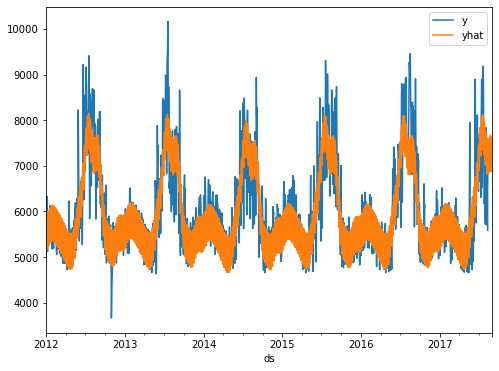

In [16]:
# for whole year predict
pd.concat([df_final.set_index('ds')['y'] , forcast.set_index('ds')['yhat']],axis=1).plot()

<AxesSubplot:xlabel='ds'>

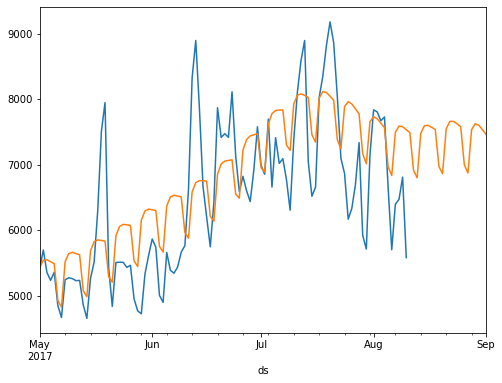

In [17]:
# for test data seeing
test.set_index('ds')['y'].plot()
forcast.iloc[len(train):,:].set_index('ds')['yhat'].plot()

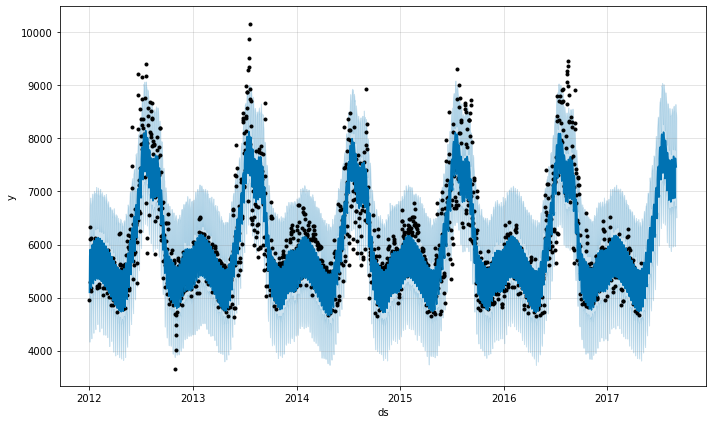

In [18]:
fig1 = model.plot(forcast)

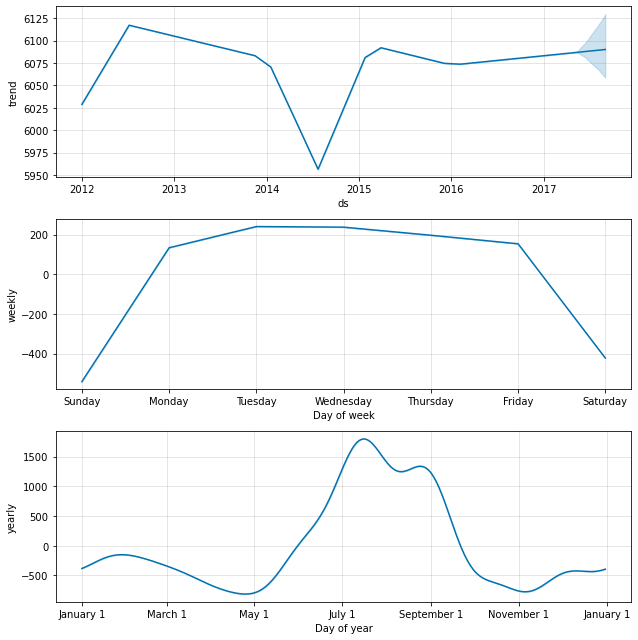

In [19]:
fig2 = model.plot_components(forcast)

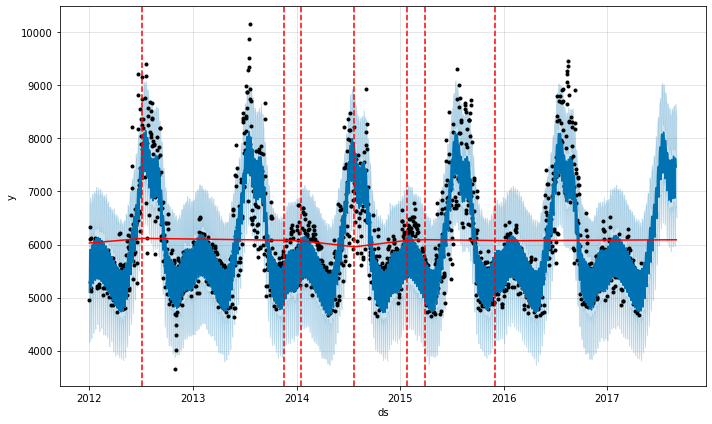

In [20]:
## change points.. max 25 change points
## we can add custom change points
## we can see simalrity with change point and trend plot above

from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(forcast)
a = add_changepoints_to_plot(fig.gca(),model ,forcast)

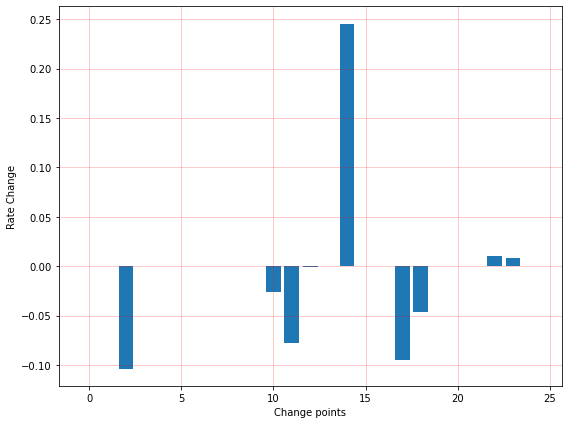

In [21]:
# this plot showing the change point the  max change point is 25
# but we can override this change points
# down bar showing neg change point and up bar postive change point

delta = model.params['delta'].mean(0)

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(delta)), delta)
ax.grid(True , which='major' , c='red', ls='-' , lw=1 , alpha=0.2)
ax.set_ylabel('Rate Change')
ax.set_xlabel('Change points')
fig.tight_layout()

In [22]:
## change point output
## the dates where change points occurs
model.changepoints

62     2012-03-03
124    2012-05-04
187    2012-07-06
249    2012-09-06
311    2012-11-07
373    2013-01-08
436    2013-03-12
498    2013-05-13
560    2013-07-14
622    2013-09-14
685    2013-11-16
747    2014-01-17
809    2014-03-20
871    2014-05-21
934    2014-07-23
996    2014-09-23
1058   2014-11-24
1120   2015-01-25
1183   2015-03-29
1245   2015-05-30
1307   2015-07-31
1369   2015-10-01
1432   2015-12-03
1494   2016-02-03
1556   2016-04-05
Name: ds, dtype: datetime64[ns]

In [25]:
## cross validation
## model is what we above define Prohept()
## Here we using initial 731 days data and give predication of 365 days
## it takes 50% or 365 days = 180 days and for evry 180 days it runs a internal cross validation 
## so 731/180 = 4 then remaining is 1 so it creating the 4+1=5 forcaste

from fbprophet.diagnostics import cross_validation
cv_result = cross_validation( model = model, initial='731 days' , horizon='365 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-01 00:00:00 and 2016-04-30 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [27]:
cv_result.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-05-02,5563.525540,4669.950965,6356.769185,5460.325000,2014-05-01
1,2014-05-03,4973.621663,4162.995566,5816.203319,4893.683333,2014-05-01
2,2014-05-04,4849.831474,4060.771352,5699.074290,4764.137500,2014-05-01
3,2014-05-05,5530.813885,4738.032039,6331.052620,5406.762500,2014-05-01
4,2014-05-06,5625.821994,4871.200138,6435.518175,5409.750000,2014-05-01


In [29]:
### now it showing the rmse wrt days
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(cv_result)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days 12:00:00,251533.449535,501.531105,405.437809,0.072880,0.065090,0.884615
1,37 days 00:00:00,258330.567980,508.262302,412.884031,0.074176,0.065748,0.879121
2,37 days 12:00:00,260587.325466,510.477546,416.203528,0.074746,0.066774,0.879121
3,38 days 00:00:00,263443.890966,513.267855,419.332929,0.075014,0.067436,0.879121
4,38 days 12:00:00,267080.896377,516.798700,424.495767,0.075838,0.067820,0.879121
...,...,...,...,...,...,...,...
653,363 days 00:00:00,259308.715576,509.223640,447.075399,0.082531,0.082341,0.983516
654,363 days 12:00:00,260793.587993,510.679536,447.981302,0.082691,0.082341,0.978022
655,364 days 00:00:00,265328.210627,515.100195,451.682966,0.083560,0.083240,0.978022
656,364 days 12:00:00,265197.365508,514.973170,451.215629,0.083511,0.083240,0.978022
